# Conv1D layer input shape

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(51)

In [2]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = 0.1 * time # trend series 생성  

amplitude = 40
slope = 0.05
noise_level = 5

# trend와 seasonality가 포함된 series 생성
series = baseline + slope * time + \
        seasonality(time, period=365, amplitude=amplitude)
# noise 추가
series += np.random.randn(len(time)) 

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

batch_size = 32

### Conv1D 용 windowed dataset 생성

Examples:

- The inputs are 128-length vectors with 10 timesteps, and the batch size is 4.  

    - input_shape = (4, 10, 128)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)     # for conv1d
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### Helper Function

- training 후 series data를 model 입력 사양에 맞추기 위해 사용

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
window_size = 30
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, 
                    batch_size, shuffle_buffer_size)
train_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float32, tf.float32)>

## Conv1D + LSTM + Bidirectional

- `causal` results in causal (dilated) convolutions, e.g. 출력[t]는 입력[t + 1:]에 의존하지 않습니다.

- Causal padding 은 `Conv1D`에만 지원됩니다.

- `dilation rate`은 커널 사이의 간격을 정의. `dilation rate`가 2인 3x3 커널은 9개의 파라미터를 사용하면서 5x5 커널과 동일한 시야(view)를 가짐. 5x5 커널을 사용하고 두번째 열과 행을 모두 삭제하면 (3x3 커널을 사용한 경우 대비)동일한 계산 비용으로 더 넓은 시야를 제공. Dilated convolution은 특히 real-time segmentation 분야에서 주로 사용. 넓은 시야가 필요하고 여러 convolution이나 큰 커널을 사용할 여유가 없는 경우 사용

In [6]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", 
                         activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 250)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, None, 1)           65        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-traina

In [7]:
%%time
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule])

CPU times: user 1min 19s, sys: 14.8 s, total: 1min 34s
Wall time: 1min 9s


(1e-08, 0.0001, 0.0, 30.0)

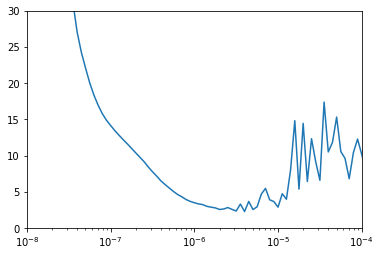

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

### optimal learning rate로 충분한 epoch train

- kernel size를 3으로 조정하고, Lambda layer 를 `x * 200`으로 조정

In [9]:
%%time
tf.keras.backend.clear_session()
train_set = windowed_dataset(x_train, window_size, 
                    batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", 
                         activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=500, verbose=0)

CPU times: user 6min 4s, sys: 1min 12s, total: 7min 16s
Wall time: 5min 11s


In [10]:
print(series.shape)
print(series[:, np.newaxis].shape)
print(series[..., np.newaxis].shape)

(1461,)
(1461, 1)
(1461, 1)


In [11]:
forecast = model_forecast(model, series[..., np.newaxis], window_size)
forecast = forecast[split_time-window_size:-1, -1, 0]
forecast.shape

(461,)

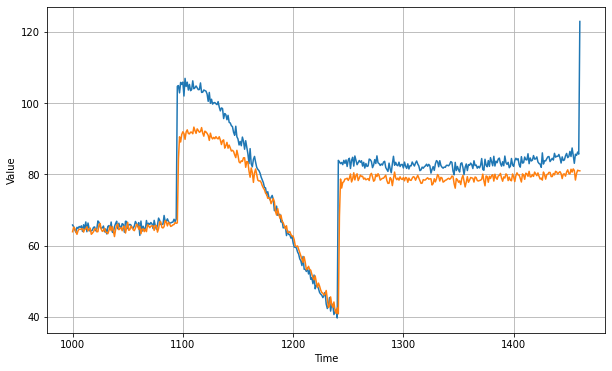

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, forecast)
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

4.1201196

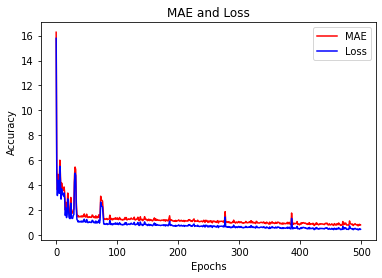

In [14]:
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

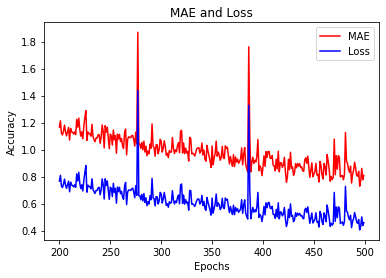

In [15]:
plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])